In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "24"

import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import scanpy as sc
from hits.visualize import interactive
from bokeh.io import output_notebook
from hdbscan import HDBSCAN

from perturbseq import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

Loading BokehJS ...

# Parameters

In [2]:
full_pop = sc.read_h5ad('/data/norman/southark/tfs_standardized/240116_fibroblast_CRISPRa_scanpy_from_cellranger_aggr_singlets_and_multiplets_5umi_guide_thresh.h5ad')

In [3]:
full_pop = full_pop[:, full_pop.var['mean'] > 0].copy()

In [4]:
full_pop = CellPopulation(pd.DataFrame(full_pop.X.todense().A, index=full_pop.obs.index, columns=full_pop.var.index), full_pop.obs, full_pop.var, calculate_statistics=False)

Done.


In [5]:
full_pop.cells['guide_identity'] = full_pop.cells['guide_identity'].astype(str)
full_pop.cells['guide_target'] = full_pop.cells['guide_identity'].map(lambda x: x.split('_')[0])
full_pop.genes['in_matrix'] = True

In [6]:
full_pop.cells['gem_group'] = full_pop.cells.index.map(lambda x: int(x.split('-')[1]))

# Droplet quality filtering

In [7]:
full_pop.cells.groupby('gem_group')['UMI_count'].mean()

gem_group
1     10479.506836
2     10977.286133
3     10241.153320
4     10263.859375
5     11145.986328
6     10999.364258
7     11029.822266
8      9320.790039
9      7520.938965
10     7227.572266
11     7235.270508
12     6860.453125
13     7933.786621
14     8014.250000
15     7768.224121
16     8032.437988
Name: UMI_count, dtype: float32

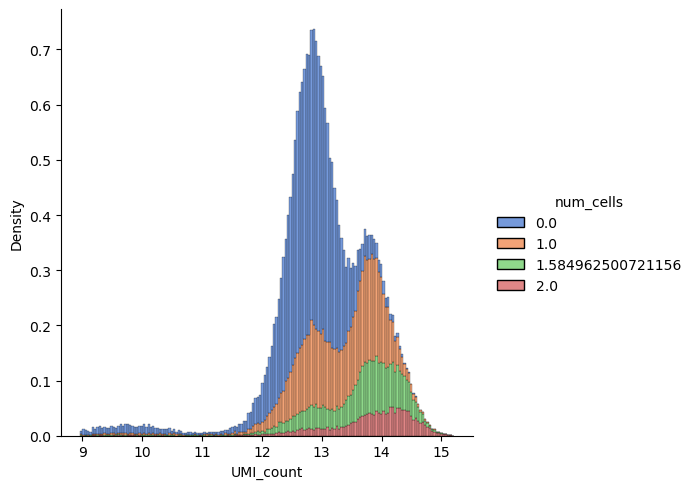

In [8]:
sns.displot(data=np.log2(full_pop.cells.query('gem_group <= 7 and num_cells <= 4')[['UMI_count', 'num_cells']]), x='UMI_count', hue='num_cells', palette='muted', stat='density', multiple='stack')

In [9]:
UMI_thresholds = {1: 2**11, 2: 2**11.5, 3: 2**11.7, 4: 2**12}

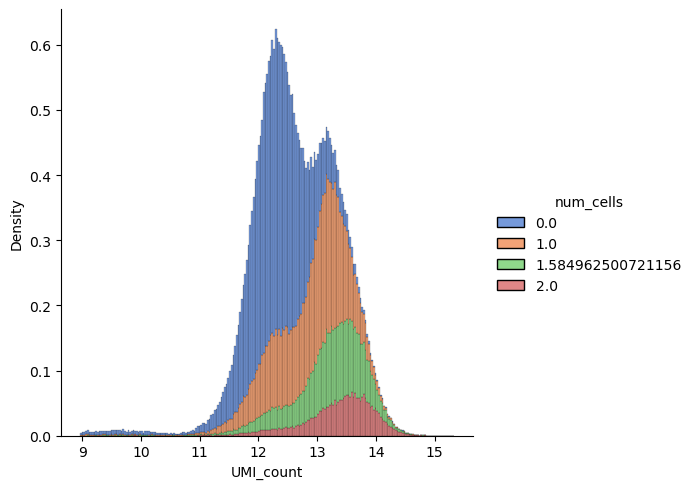

In [10]:
sns.displot(data=np.log2(full_pop.cells.query('gem_group > 7 and num_cells <= 4')[['UMI_count', 'num_cells']]), x='UMI_count', hue='num_cells', palette='muted', stat='density', multiple='stack')

In [11]:
UMI_thresholds2 = {1: 2**10.7, 2: 2**11, 3: 2**11.3, 4: 2**11.5}

In [12]:
df = full_pop.cells.query('gem_group==1 and num_cells <= 4')[['UMI_count', 'num_cells']]

In [13]:
df.columns = ['UMI count', 'number of cells in droplet']

(0.0, 30000.0)

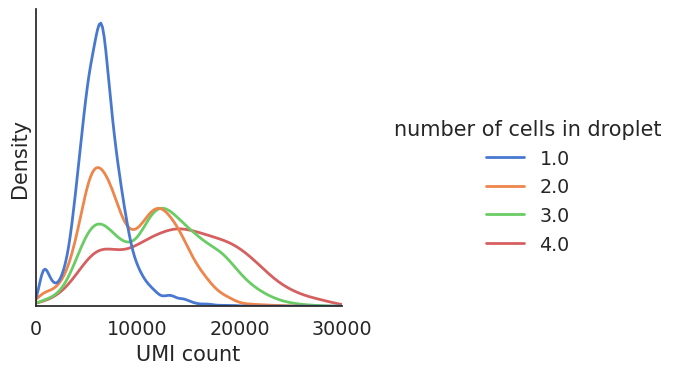

In [14]:
sns.set(font_scale=1.25)
sns.set_style('white')
sns.displot(data=df,
            x='UMI count', hue='number of cells in droplet', palette='muted', kind='kde', common_norm=False,
           height=4, aspect=1.25, linewidth=2)
plt.yticks([])
plt.xlim([0, 30000])

In [15]:
df = full_pop.cells.query('gem_group==1 and num_cells <= 10')[['UMI_count', 'num_cells']].groupby('num_cells').median()

Text(0, 0.5, 'Median UMI count')

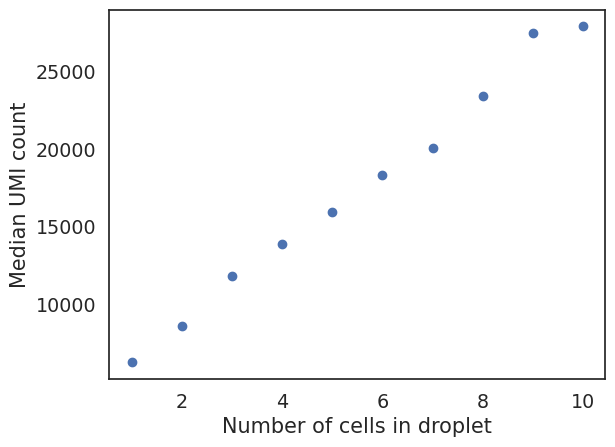

In [16]:
plt.scatter(df.index, df['UMI_count'])
plt.xlabel('Number of cells in droplet')
plt.ylabel('Median UMI count')

In [17]:
mt_genes = full_pop.genes[full_pop.genes['gene_name'].str.startswith('MT-')].query('mean > 1').index
full_pop.cells['mt_frac'] = full_pop.matrix[mt_genes].sum(axis=1)/full_pop.cells['UMI_count']

(0.0, 20000.0)

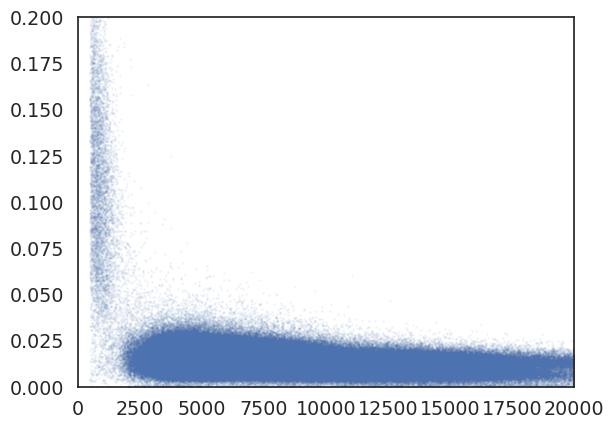

In [18]:
plt.scatter(full_pop.cells['UMI_count'], full_pop.cells['mt_frac'], s=1, alpha=0.05)
plt.ylim([0, 0.2])
plt.xlim([0, 20000])

In [19]:
full_pop.cells['keep'] = (((full_pop.cells['gem_group'] <= 7) & (full_pop.cells['UMI_count'] > full_pop.cells['num_cells'].map(UMI_thresholds))) \
                        | ((full_pop.cells['gem_group'] > 7) & (full_pop.cells['UMI_count'] > full_pop.cells['num_cells'].map(UMI_thresholds2)))) \
                          & (full_pop.cells['mt_frac'] < 0.05)

In [20]:
full_pop.cells.query('keep').groupby('num_cells')['num_cells'].sum().head(10)

num_cells
1.0    220403.0
2.0    253446.0
3.0    199707.0
4.0    134424.0
Name: num_cells, dtype: float64

In [21]:
full_pop.cells.query('keep').groupby('gem_group')['num_cells'].sum()

gem_group
1     28795.0
2     27397.0
3     27059.0
4     28940.0
5     31822.0
6     30964.0
7     29842.0
8     36635.0
9     71190.0
10    70395.0
11    69452.0
12    70052.0
13    71786.0
14    73803.0
15    71981.0
16    67867.0
Name: num_cells, dtype: float64

In [22]:
full_pop.cells['single_cell'] = True

In [36]:
full_pop = full_pop.subpopulation(cells='keep', calculate_statistics=False)

Done.


# Filtering of control guides for possible on-target effects

In [37]:
expr = full_pop.where('guide_target=="non" and num_cells==1', genes='mean > 1')
expr['guide_identity'] = full_pop.cells['guide_identity']
expr.set_index('guide_identity', append=True, inplace=True)
expr = (expr - expr.mean()).div(expr.std())

In [38]:
scores = pd.read_csv('20231027_sequence_scores.csv', index_col=0)['0']

In [39]:
counts = full_pop.cells.query('num_cells==1 and guide_target=="non"').groupby('guide_identity').count()['UMI_count'].sort_values()
counts.head(20)

guide_identity
non_targeting_GTAAATTCTCGCGTAACGTT     52
non_targeting_GTTCCTGTTGGGTCGCGAAT     77
non_targeting_GTGGTTATACCCGACTAGAC     77
non_targeting_GACTGAAAGCCGATATCGGG     81
non_targeting_GTGGATTATCTGACGCGAAT     82
non_targeting_GGAATCTTCGCGTAACGAGC     87
non_targeting_GTCGTTATCTCGCTATTTCG     92
non_targeting_GCTGTTTCGACCCGTCGAAT     96
non_targeting_GGATTCTGGAAAGTCGGTCG     98
non_targeting_GCCTAAATACTATTCGCGGA    100
non_targeting_GTGCTCGCGAATCGTATCGG    107
non_targeting_GTGTTTTTCGGTCGGCCGAT    110
non_targeting_GATGCTCGCAGTTCGACCGC    112
non_targeting_GACACTGGACGCGACTTATA    113
non_targeting_GTCAATACGACGAGCCGACA    114
non_targeting_GCGGGTAGCTTATATAGCGC    116
non_targeting_GGATGAAAACCCGAACCGAT    120
non_targeting_GTTGATCGACCGATTGCGAT    121
non_targeting_GTGGGTGAATGCGTACGTCG    125
non_targeting_GAGATATGAGGCGACGATAT    127
Name: UMI_count, dtype: int64

In [40]:
mean_expr = expr.groupby(level=1).mean()

In [41]:
control_guide_scores = pd.Series(mean_expr.index.map(lambda x: x[-5:]).map(scores), index=mean_expr.index)

In [42]:
control_guide_scores.sort_values().dropna().tail(20)

guide_identity
non_targeting_GTGCATCAAGTCGACCGGCG    11.698591
non_targeting_GCTCTTGGTACGTATTCGAA    11.793140
non_targeting_GGATGTCGCCACGTACGGAT    12.020473
non_targeting_GTCAATACGACGAGCCGACA    12.143612
non_targeting_GAAACAAACAGACGGACCTA    12.603942
non_targeting_GAACGGGCCGTGATCGGACC    13.147390
non_targeting_GACCAGCATTCATACGCCGG    13.827048
non_targeting_GCTTCGGGGGAATCACCGGT    14.065916
non_targeting_GACCACCGACGCGTTACGCA    14.175489
non_targeting_GCTCTGTTCGTCGTTCGCTG    14.206585
non_targeting_GCCAGACGCGCCCGTAACGG    14.662778
non_targeting_GACGAATGAAGCGTCGATAA    16.714623
non_targeting_GGCTTCTACACCGCGATGAC    16.859756
non_targeting_GGGAACAGGGGCGGTCCGTA    16.995683
non_targeting_GAGATATGAGGCGACGATAT    17.883156
non_targeting_GTCCATAGGGTCTAGCGCCG    21.004817
non_targeting_GAAGCAGCATGAATACGCCG    21.004817
non_targeting_GACTGAAAGCCGATATCGGG    22.914654
non_targeting_GCCTAAATACTATTCGCGGA    25.215185
non_targeting_GGAATCCAGCTCGACGACCA    26.143064
Name: guide_identity, dty

In [43]:
len(np.intersect1d(counts[counts > 100].index, control_guide_scores[(control_guide_scores < 15) | control_guide_scores.isnull()].index))

61

In [46]:
good_controls = np.intersect1d(counts[counts > 100].index, control_guide_scores[(control_guide_scores < 15) | control_guide_scores.isnull()].index)

In [32]:
full_pop.cells.query('num_cells==1 and guide_identity in @good_controls').groupby('gem_group').count()

,dataset,UMI_count,guide_identity,guide_umi_count,thresholded_features,thresholded_guide_umi,num_cells,guide_target,mt_frac,keep
gem_group,,,,,,,,,,
1,439,439,439,439,439,439,439,439,439,439
2,492,492,492,492,492,492,492,492,492,492
3,471,471,471,471,471,471,471,471,471,471
4,490,490,490,490,490,490,490,490,490,490
5,528,528,528,528,528,528,528,528,528,528
6,511,511,511,511,511,511,511,511,511,511
7,495,495,495,495,495,495,495,495,495,495
8,651,651,651,651,651,651,651,651,651,651
9,1009,1009,1009,1009,1009,1009,1009,1009,1009,1009


In [37]:
full_pop.cells['control'] = (full_pop.cells['num_cells'] == 1) & (full_pop.cells['guide_identity'].isin(good_controls))

# Save total UMI count population

In [38]:
from scipy.sparse import csr_matrix

In [39]:
adata = sc.AnnData(X=csr_matrix(full_pop.matrix),
                   obs=full_pop.cells,
                   var=full_pop.genes)

In [40]:
adata.write('/data/norman/southark/tfs_standardized/240308_fibroblast_CRISPRa_scanpy_from_cellranger_aggr_singlets_and_multiplets_5umi_guide_thresh_filtered_all_UMI_counts.h5ad')

# Identify stably captured genes

In [48]:
def get_p(pop, genes=None, UMI_counts=None):
    if UMI_counts is None:
        UMI_counts = pop.cells['UMI_count']
    
    ps = dict()
    
    for gem in tqdm(pop.cells['gem_group'].unique()):
        gem_group_cells = pop.cells[pop.cells['gem_group']==gem].index
        
        p = pop.where(cells=gem_group_cells, genes=genes).copy()
        # normalize to probabilities
        p = p.div(UMI_counts.loc[gem_group_cells], axis=0)
                    
        ps[gem] = p
    
    ps = pd.concat(ps.values())

    return ps

In [49]:
def get_stratified_expression(pop, stratify, cells=None, genes=None, normalized=False, normalized_name=None, **kwargs):
    expr = pop.where(cells=cells, genes=genes, normalized=normalized, normalized_name=normalized_name, **kwargs).copy()
    
    for key in stratify:
        expr[key] = pop.cells[key]
        
    expr.set_index(stratify, append=True, inplace=True)
    levels_order = expr.index.names
    new_order = levels_order[1:] + [levels_order[0]]
    expr = expr.reorder_levels(new_order)

    return expr

In [50]:
from scipy.stats import wasserstein_distance

def pairwise_sum_wasserstein(p):
    num_cells = p.index.get_level_values(0).unique()
    
    dists = list()
    for (n1, n2) in combinations(num_cells, 2):
        dists.append(wasserstein_distance(p.loc[n1], p.loc[n2]))
    return np.sum(dists)

In [51]:
full_pop.normalized_matrix = dict()

In [52]:
full_pop.normalized_matrix['p'] = get_p(full_pop)

  0%|          | 0/16 [00:00<?, ?it/s]

In [53]:
p = get_stratified_expression(full_pop,
                              ['gem_group', 'num_cells'],
                              genes='mean > 0.5',
                              normalized=True, normalized_name='p')

In [54]:
from itertools import combinations

In [56]:
def process_gem_group(gem_group):
    local_dists = dict()
    gem_group_p = p.loc[gem_group]
    for gene, col in gem_group_p.iteritems():
        local_dists[(gem_group, gene)] = pairwise_sum_wasserstein(col)
    return local_dists

# Parallelize the outer loop
n_jobs = 10  # Use all available cores
gem_groups = p.index.get_level_values(0).unique()
results = Parallel(n_jobs=n_jobs)(delayed(process_gem_group)(gem_group) for gem_group in tqdm(gem_groups, total=len(gem_groups)))

# Merge the results from all workers into the main dict
dists = {k: v for res in results for k, v in res.items()}

  0%|          | 0/16 [00:00<?, ?it/s]

In [57]:
full_pop.genes['pairwise_p_cost'] = np.log10(pd.Series(dists).unstack().sum())

In [58]:
def pairwise_sum_hellinger(p):
    num_cells = p.index.get_level_values(0).unique()
    
    dists = list()
    for (n1, n2) in combinations(num_cells, 2):
        dists.append(empirical_hellinger(p.loc[n1], p.loc[n2]))
    return np.sum(dists)

## Fitting adjusted total cost

In [61]:
from sklearn.linear_model import HuberRegressor

regr = HuberRegressor()
X = np.log10(full_pop.genes.query('mean > 0.5')['mean']).values.reshape(-1, 1)
y = full_pop.genes.query('mean > 0.5')['pairwise_p_cost']

regr.fit(X, y)
pred_costs = pd.Series(regr.predict(X), index=y.index)
full_pop.genes['mean_adjusted_pairwise_p_cost'] = full_pop.genes['pairwise_p_cost'] - pred_costs

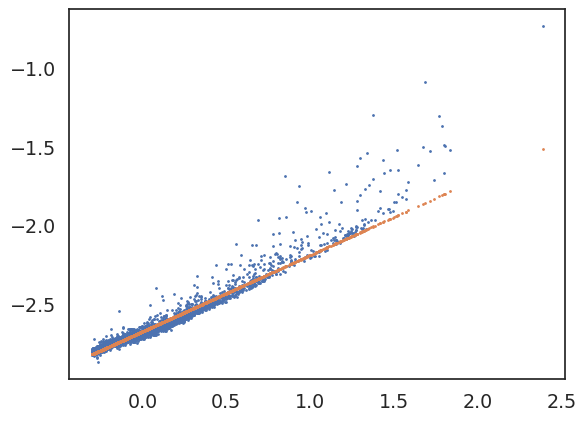

In [62]:
plt.scatter(np.log10(full_pop.genes.query('mean > 0.5')['mean']),
           full_pop.genes.query('mean > 0.5')['pairwise_p_cost'], s=1)

plt.scatter(np.log10(full_pop.genes.query('mean > 0.5')['mean']),
           pred_costs, s=1)

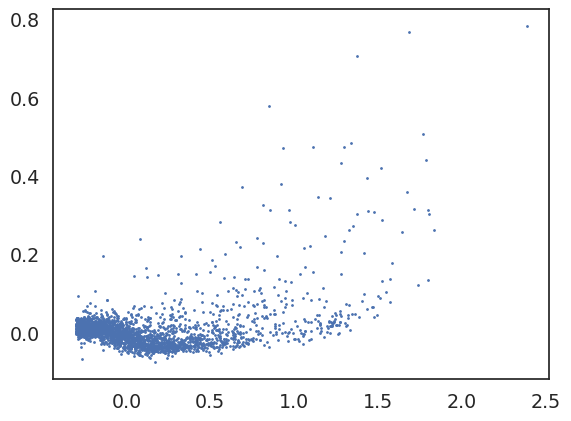

In [63]:
plt.scatter(np.log10(full_pop.genes.query('mean > 0.5')['mean']),
           full_pop.genes.query('mean > 0.5')['mean_adjusted_pairwise_p_cost'], s=1)

## Fitting excess CV

In [67]:
from scipy.signal import medfilt
from scipy.interpolate import interp1d

def calculate_excess_cv(pop, mean_threshold=0.05, exclude=[], resolution=1000):
    """Calculates the excess coefficient of variation (CV) for each gene.
    
    Args:
        pop: CellPopulation instance
        mean_threshold: only consider genes with mean expression level above this value
        exclude: list of gene names or gene ids to not include in the calculation
        resolution: number of bins to use when interpolating mean-CV relationship
        
    Returns:
        Series of excess CV for each gene.
    """
    if len(exclude) > 0:
        exclude = pop.gene_ids(exclude)
    
    thresholded_genes = pop.genes.query('mean > @mean_threshold').sort_values('mean', ascending=False)
    thresholded_genes = thresholded_genes.query('index not in @exclude')
    
    gene_means_mean_ordered = thresholded_genes['mean']
    gene_cvs_mean_ordered = thresholded_genes['cv']
    gene_cvs_mean_ordered_medfilt = pd.Series(medfilt(gene_cvs_mean_ordered, kernel_size=15), index=gene_cvs_mean_ordered.index)
    
    ind = np.arange(0, len(gene_means_mean_ordered), len(gene_means_mean_ordered)/resolution)
    cv_interpolater = interp1d(gene_means_mean_ordered.iloc[ind], gene_cvs_mean_ordered_medfilt.iloc[ind], fill_value="extrapolate")
    
    predicted_cv = pd.Series(cv_interpolater(gene_means_mean_ordered), index=gene_means_mean_ordered.index)
    excess_cv = gene_cvs_mean_ordered/predicted_cv
    thresholded_genes['excess_cv'] = excess_cv
    
    return thresholded_genes['excess_cv']


In [76]:
full_pop.genes['excess_cv'] = calculate_excess_cv(full_pop, mean_threshold=0.195)

/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='excess_cv', ylabel='Density'>

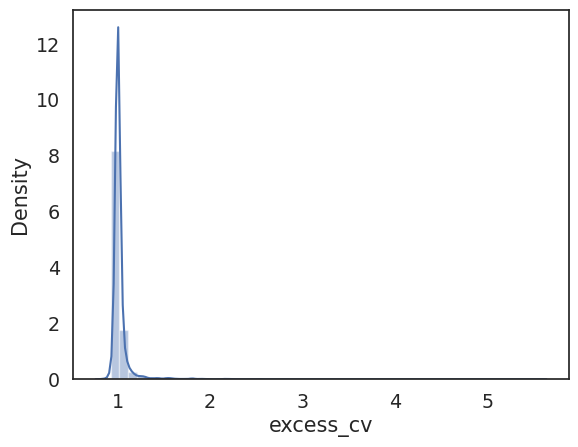

In [77]:
sns.distplot(full_pop.genes['excess_cv'])

In [78]:
full_pop.genes['excess_cv'].describe()

count    4997.000000
mean        1.022136
std         0.124958
min         0.827020
25%         0.992709
50%         1.000000
75%         1.013199
max         5.572756
Name: excess_cv, dtype: float64

/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mean_adjusted_pairwise_p_cost', ylabel='Density'>

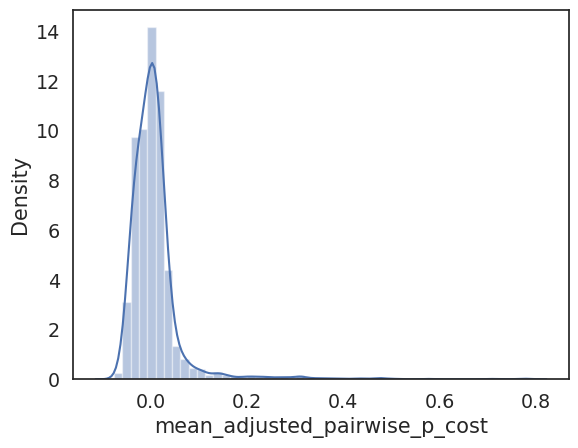

In [79]:
sns.distplot(full_pop.genes['mean_adjusted_pairwise_p_cost'])

## Picking stably captured genes

In [83]:
full_pop.genes['pairwise_chosen'] = full_pop.genes.index.isin(full_pop.genes.dropna(subset='mean_adjusted_pairwise_p_cost').query('excess_cv < 1 and mean_adjusted_pairwise_p_cost < {0:0.8f}'.format(full_pop.genes['mean_adjusted_pairwise_p_cost'].quantile(0.3))).index)

In [85]:
full_pop.genes['pairwise_chosen'].sum()

397

# Fit scale coefficients to stable genes

In [86]:
from joblib import Parallel, delayed
from sklearn.linear_model import HuberRegressor

def fit_robust_regression(x, y, name=None, fit_intercept=False):
    # Convert pandas series to numpy array as required by sklearn
    x_np = x.to_numpy().reshape(-1, 1)
    y_np = y.to_numpy()
    
    # Instantiate a HuberRegressor object with no intercept
    huber = HuberRegressor(fit_intercept=fit_intercept, max_iter=500)
    
    # Fit the Huber regression model to the data
    try:
        huber.fit(x_np, y_np)
        coef = huber.coef_[0]
        umi_pred = huber.predict(x_np).sum()
        raw_umi_pred = x_np.sum()
    except ValueError:
        coef = np.nan
        umi_pred = np.nan
        raw_umi_pred = np.nan
        
    if not fit_intercept:
        if name is None:
            return (coef, umi_pred, raw_umi_pred)
        else:
            return (name, coef, umi_pred, raw_umi_pred)
    else:
        if name is None:
            return (coef, huber.intercept_, umi_pred, raw_umi_pred)
        else:
            return (name, coef, huber.intercept_, umi_pred, raw_umi_pred)

def get_mean_coefs(pop, stable_genes, trim=None, fit_intercept=False):    
    all_coefs = dict()
    
    for gem in tqdm(pop.cells['gem_group'].unique()):
        for num in pop.cells['num_cells'].unique():
            target_cells = pop.cells[(pop.cells['gem_group']==gem) & (pop.cells['num_cells']==num)].index
            stable_expr = pop.where(cells=target_cells,
                                    genes=stable_genes)
            if trim is None:
                stable_mean_expr = stable_expr.mean()
            else:
                stable_mean_expr = stable_expr.apply(lambda x: trim_mean(x, trim))

            coefs = Parallel(n_jobs=16, verbose=10)(delayed(fit_robust_regression)(row, stable_mean_expr, name=cell_bc, fit_intercept=fit_intercept) for cell_bc, row in stable_expr.iterrows())

            if not fit_intercept:
                all_coefs[(gem, num)] = pd.DataFrame(coefs, columns=['cell_barcode', 'huber_coef', 'huber_UMI_count', 'raw_huber_UMI_count']).set_index('cell_barcode')
            else:
                all_coefs[(gem, num)] = pd.DataFrame(coefs,
                                              columns=['cell_barcode', 'huber_intercept_coef', 'huber_intercept', 'huber_intercept_UMI_count', 'raw_huber_intercept_UMI_count']).set_index('cell_barcode')
    
    return pd.concat(all_coefs.values())

In [87]:
pairwise_mean_coefs = get_mean_coefs(full_pop, full_pop.genes.query('pairwise_chosen').index)

  0%|          | 0/16 [00:00<?, ?it/s]

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:   23.4s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   23.5s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:   23.5s
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:   23.5s
[Parallel(n_jobs=16)]: Batch computation too fast (0.19529993387400943s.) Setting batch_size=2.
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:   23.6s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:   23.6s
[Parallel(n_jobs=16)]: Done  82 tasks      | elapsed:   23.6s
[Parallel(n_jobs=16)]: Batch computation too fast (0.07944536209106445s.) Setting batch_size=4.
[Parallel(n_jobs=16)]: Done 112 tasks      | elapsed:   23.7s
[Parallel(n_jobs=16)]: Done 148 tasks      | elapsed:   23.7s
[Parallel(n_jobs=16)]: Batch computation too fast (0.08766746520996094s.) Setting batch_size=8.
[Parallel(n_jobs=16)]: Done 216 tasks      | elapsed:   23.8s
[Parallel(n_job

[Parallel(n_jobs=16)]: Done 1138 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done 1165 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done 1192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done 1221 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done 1272 out of 1272 | elapsed:    1.1s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Batch computation too fast (0.021004915237426758s.) Setting batch_size=2.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Batch computation too fast (0.08019161224365234s.) Setting batch_size=4.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  74 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Batch computation too fast (0.08931660652160645s.) Setting batch_size=8.

[Parallel(n_jobs=16)]: Done  74 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Batch computation too fast (0.08713722229003906s.) Setting batch_size=8.
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 164 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 224 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Batch computation too fast (0.10329365730285645s.) Setting batch_size=16.
[Parallel(n_jobs=16)]: Done 360 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Batch computation too fast (0.15110349655151367s.) Setting batch_size=32.
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 816 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 1248 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Batch computation too fast (0.19783060761784188s.) Setting batch_size=64.
[Parallel(n_jobs=16)]: Done 1703 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done 1813 out of 2049 | elapse

[Parallel(n_jobs=16)]: Done 2130 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 2157 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 2184 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done 2242 out of 2242 | elapsed:    1.4s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Batch computation too fast (0.04247641563415527s.) Setting batch_size=2.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Batch computation too fast (0.06911969184875488s.) Setting batch_size=4.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  74 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Batch computation too fast (0.10247015953063965s.) Setting batch_size=8.
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.3s
[

[Parallel(n_jobs=16)]: Done 360 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Batch computation too fast (0.1981678009033203s.) Setting batch_size=32.
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 816 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done 1248 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done 1920 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 2592 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done 3328 tasks      | elapsed:    1.7s
[Parallel(n_jobs=16)]: Done 4064 tasks      | elapsed:    1.8s
[Parallel(n_jobs=16)]: Done 4414 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done 4494 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 4698 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 4752 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 4810 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 4868 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Do

[Parallel(n_jobs=16)]: Done  74 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Batch computation too fast (0.09296917915344238s.) Setting batch_size=8.
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 164 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 224 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Batch computation too fast (0.11927366256713867s.) Setting batch_size=16.
[Parallel(n_jobs=16)]: Done 360 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Batch computation too fast (0.15227675437927246s.) Setting batch_size=32.
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 816 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 1248 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done 1920 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done 2592 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 3328 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: D

[Parallel(n_jobs=16)]: Batch computation too fast (0.1747589111328125s.) Setting batch_size=32.
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done 816 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done 1248 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 1920 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done 2592 tasks      | elapsed:    1.7s
[Parallel(n_jobs=16)]: Done 3328 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Batch computation too fast (0.19996699178769112s.) Setting batch_size=64.
[Parallel(n_jobs=16)]: Done 4064 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done 4275 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 4616 out of 4616 | elapsed:    2.0s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Batch computation too fast (0.05000805854797363s.) Setting batch_size=2.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.

[Parallel(n_jobs=16)]: Done 5714 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done 5745 tasks      | elapsed:    2.3s
[Parallel(n_jobs=16)]: Done 5779 out of 5779 | elapsed:    2.3s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Batch computation too fast (0.04062008857727051s.) Setting batch_size=2.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Batch computation too fast (0.07258987426757812s.) Setting batch_size=4.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  74 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Batch computation too fast (0.09812164306640625s.) Setting batch_size=8.
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 164 tasks      | elapsed:    0.3s
[P

[Parallel(n_jobs=16)]: Done 4864 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 5664 tasks      | elapsed:    2.3s
[Parallel(n_jobs=16)]: Done 6528 tasks      | elapsed:    2.8s
[Parallel(n_jobs=16)]: Done 7392 tasks      | elapsed:    3.2s
[Parallel(n_jobs=16)]: Done 8320 tasks      | elapsed:    3.4s
[Parallel(n_jobs=16)]: Done 9248 tasks      | elapsed:    3.7s
[Parallel(n_jobs=16)]: Done 10240 tasks      | elapsed:    3.9s
[Parallel(n_jobs=16)]: Batch computation too fast (0.1998028692158215s.) Setting batch_size=64.
[Parallel(n_jobs=16)]: Done 10953 tasks      | elapsed:    4.0s
[Parallel(n_jobs=16)]: Done 11274 out of 11274 | elapsed:    4.1s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Batch computation too fast (0.04674696922302246s.) Setting batch_size=2.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Don

[Parallel(n_jobs=16)]: Done 360 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Batch computation too fast (0.1707780361175537s.) Setting batch_size=32.
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 816 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 1248 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done 1920 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done 2592 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 3328 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done 4064 tasks      | elapsed:    1.7s
[Parallel(n_jobs=16)]: Done 4864 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done 5664 tasks      | elapsed:    2.4s
[Parallel(n_jobs=16)]: Done 6528 tasks      | elapsed:    2.6s
[Parallel(n_jobs=16)]: Done 7392 tasks      | elapsed:    2.9s
[Parallel(n_jobs=16)]: Done 8320 tasks      | elapsed:    3.2s
[Parallel(n_jobs=16)]: Done 9248 tasks      | elapsed:    3.4s
[Parallel(n_jobs=16)]: Do

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Batch computation too fast (0.0408635139465332s.) Setting batch_size=2.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Batch computation too fast (0.06410980224609375s.) Setting batch_size=4.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  74 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Batch computation too fast (0.09730029106140137s.) Setting batch_size=8.
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 164 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 224 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Batch computation too fast (0.10097384452819824s.) Setting batch_size=16.
[Parallel(n_jobs=16)]: Done 360 tasks      

[Parallel(n_jobs=16)]: Done 360 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Batch computation too fast (0.1788797378540039s.) Setting batch_size=32.
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 816 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 1248 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done 1920 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done 2592 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Batch computation too fast (0.1979724951793761s.) Setting batch_size=64.
[Parallel(n_jobs=16)]: Done 3328 tasks      | elapsed:    1.6s
[Parallel(n_jobs=16)]: Done 4064 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done 4764 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 4984 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 5152 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 5440 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done 5556 tasks      | elapsed: 

[Parallel(n_jobs=16)]: Done 2674 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 2724 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 2778 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done 2854 out of 2885 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=16)]: Done 2885 out of 2885 | elapsed:    1.5s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Batch computation too fast (0.04545855522155762s.) Setting batch_size=2.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Batch computation too fast (0.08740568161010742s.) Setting batch_size=4.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  74 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Batch computation too fast (0.09063577651977539s.) Se

[Parallel(n_jobs=16)]: Done 360 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Batch computation too fast (0.151719331741333s.) Setting batch_size=32.
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 816 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 1248 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done 1920 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done 2592 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 3561 out of 3561 | elapsed:    1.4s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Batch computation too fast (0.02536630630493164s.) Setting batch_size=2.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Batch computation too fast (0.11194896697998047s.) Setting batch_size=4.
[P

[Parallel(n_jobs=16)]: Done  74 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Batch computation too fast (0.10705232620239258s.) Setting batch_size=8.
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 164 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 224 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Batch computation too fast (0.13005661964416504s.) Setting batch_size=16.
[Parallel(n_jobs=16)]: Done 360 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Batch computation too fast (0.15881896018981934s.) Setting batch_size=32.
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 816 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 1248 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done 1920 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done 2561 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done 2801 tasks      | elapsed:    1.6s
[Parallel(n_jobs=16)]: B

[Parallel(n_jobs=16)]: Done 17952 tasks      | elapsed:    6.2s
[Parallel(n_jobs=16)]: Batch computation too fast (0.19255735564340443s.) Setting batch_size=64.
[Parallel(n_jobs=16)]: Done 18425 tasks      | elapsed:    6.3s
[Parallel(n_jobs=16)]: Done 18464 tasks      | elapsed:    6.4s
[Parallel(n_jobs=16)]: Done 18505 tasks      | elapsed:    6.4s
[Parallel(n_jobs=16)]: Done 18546 tasks      | elapsed:    6.5s
[Parallel(n_jobs=16)]: Done 18589 tasks      | elapsed:    6.6s
[Parallel(n_jobs=16)]: Done 18632 tasks      | elapsed:    6.6s
[Parallel(n_jobs=16)]: Done 18700 out of 18700 | elapsed:    6.7s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Batch computation too fast (0.01962566375732422s.) Setting batch_size=2.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]

[Parallel(n_jobs=16)]: Done 3328 tasks      | elapsed:    1.6s
[Parallel(n_jobs=16)]: Done 4064 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 4864 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done 5664 tasks      | elapsed:    2.4s
[Parallel(n_jobs=16)]: Done 6528 tasks      | elapsed:    2.6s
[Parallel(n_jobs=16)]: Done 7392 tasks      | elapsed:    2.9s
[Parallel(n_jobs=16)]: Done 8320 tasks      | elapsed:    3.2s
[Parallel(n_jobs=16)]: Done 9248 tasks      | elapsed:    3.4s
[Parallel(n_jobs=16)]: Done 10240 tasks      | elapsed:    3.7s
[Parallel(n_jobs=16)]: Done 11232 tasks      | elapsed:    3.9s
[Parallel(n_jobs=16)]: Done 12288 tasks      | elapsed:    4.2s
[Parallel(n_jobs=16)]: Done 13344 tasks      | elapsed:    4.5s
[Parallel(n_jobs=16)]: Done 14464 tasks      | elapsed:    4.9s
[Parallel(n_jobs=16)]: Done 15584 tasks      | elapsed:    5.5s
[Parallel(n_jobs=16)]: Done 16768 tasks      | elapsed:    5.8s
[Parallel(n_jobs=16)]: Batch computation too fas

In [88]:
pairwise_mean_coefs['UMI_count'] = full_pop.cells['UMI_count']
pairwise_mean_coefs['num_cells'] = full_pop.cells['num_cells']
pairwise_mean_coefs['pred_UMI_count'] = pairwise_mean_coefs['UMI_count']*pairwise_mean_coefs['huber_coef']
pairwise_mean_coefs['gem_group'] = full_pop.cells['gem_group']

In [89]:
sns.set_style('white')

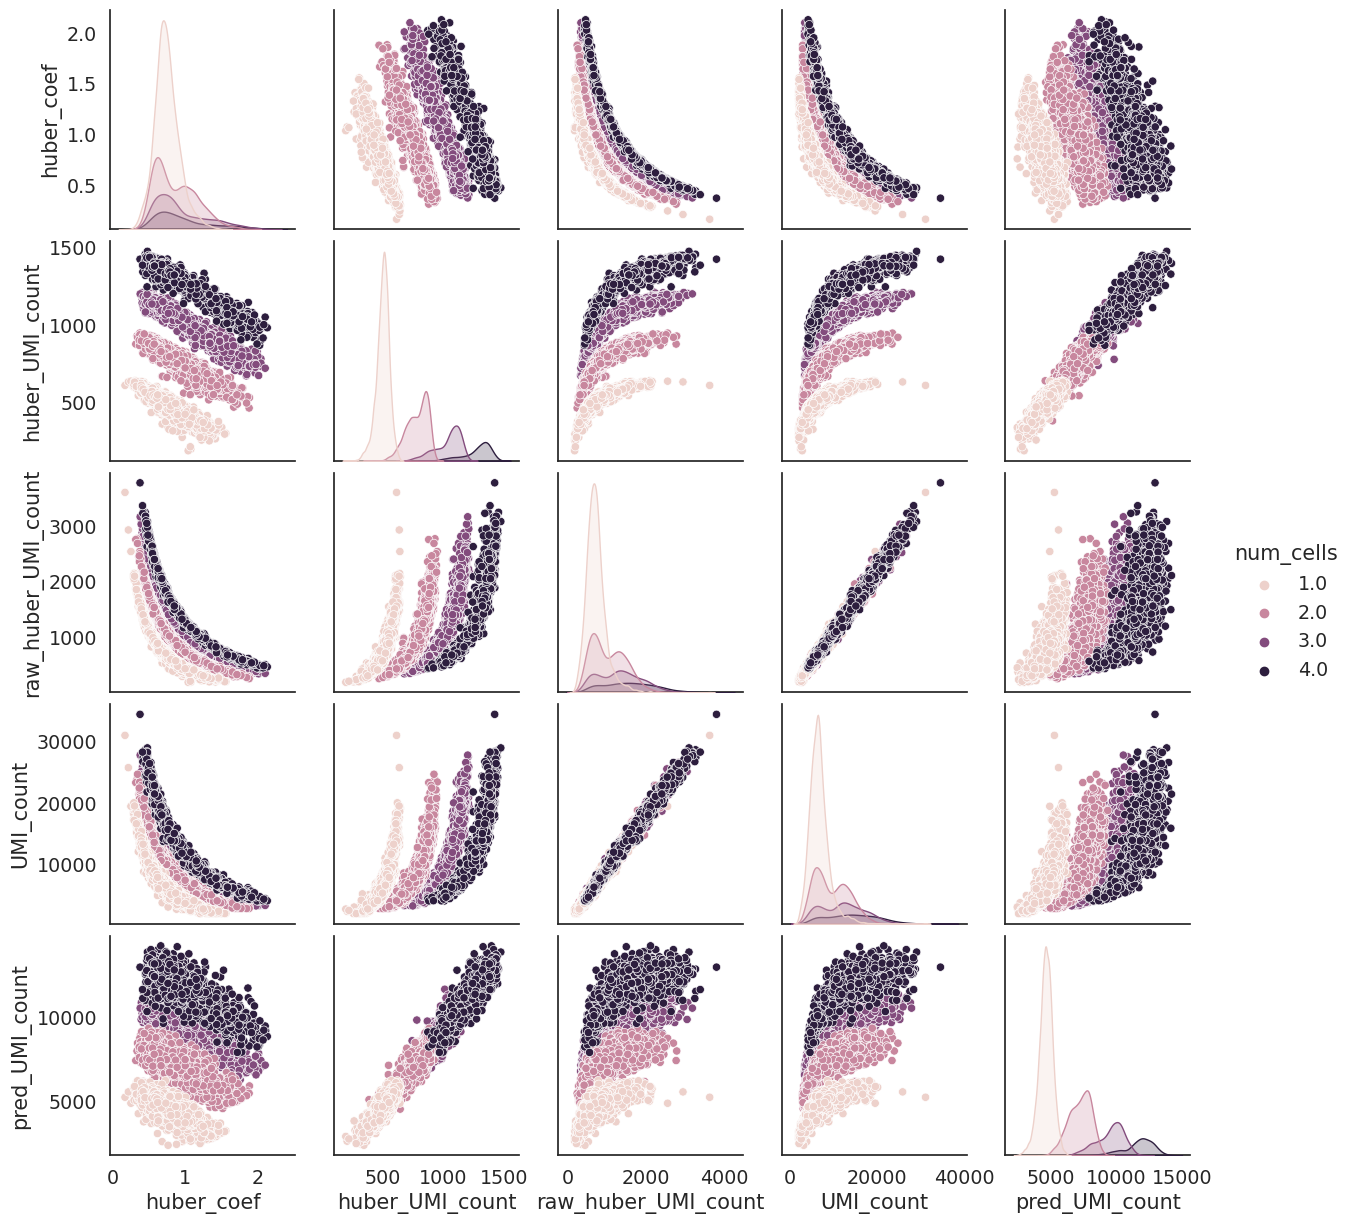

In [90]:
sns.pairplot(pairwise_mean_coefs.query('gem_group==1').drop('gem_group', axis=1), hue='num_cells')

In [91]:
full_pop.cells['pairwise_coef'] = pairwise_mean_coefs['huber_coef']
full_pop.cells['pairwise_UMI_count'] = pairwise_mean_coefs['pred_UMI_count']

In [96]:
full_pop.cells['pairwise_singlet_equivalent_UMI_count'] = full_pop.cells['pairwise_UMI_count']/full_pop.cells.groupby(['gem_group', 'num_cells'])['pairwise_UMI_count'].transform('median')

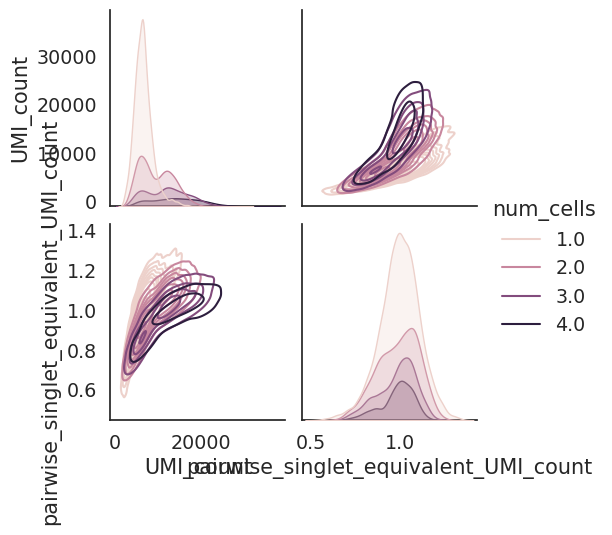

In [98]:
sns.pairplot(full_pop.cells.query('gem_group==1')[['UMI_count', 'pairwise_singlet_equivalent_UMI_count', 'num_cells']],
             hue='num_cells', kind='kde')

# Normalize capture probabilities

In [99]:
from scipy.stats import trim_mean

def p_normalize(pop, genes=None, UMI_counts=None, UMI_constant=10000, normalize_to_constant=True, scale_by_num_cells=False, normalize_to_singlets=False, trim=False, proportion_to_cut=0.02):
    if UMI_counts is None:
        UMI_counts = pop.cells['UMI_count']
    
    normalized = dict()
    
    for gem in tqdm(pop.cells['gem_group'].unique()):
        gem_group_cells = pop.cells[pop.cells['gem_group']==gem].index
        
        p = pop.where(cells=gem_group_cells, genes=genes).copy()
        # normalize to probabilities
        p = p.div(UMI_counts.loc[gem_group_cells], axis=0)
        
        p['num_cells'] = pop.cells['num_cells']
        p.set_index('num_cells', append=True, inplace=True)
        
        # observed average probability per transcript by num_cells
        if trim: # trimmed mean to reduce dependence on outliers
            P = dict()
            for level, df in p.groupby(level=1):
                P[level] = df.apply(lambda x: trim_mean(x, proportion_to_cut))
            P = pd.DataFrame(P).T
        else:
            P = p.groupby(level=1).mean()
        
        if normalize_to_singlets:
            mu = P.loc[1]
        else:
            if trim:
                mu = p.apply(lambda x: trim_mean(x, proportion_to_cut))
            else:
                mu = p.mean()
        
        # normalize to equal average probability across all droplets to yield scale factors
        Q = P.div(mu)
        
        factors = pd.DataFrame(Q.loc[p.index.get_level_values(1)].values, index=p.index, columns=p.columns)
        
        if normalize_to_constant and scale_by_num_cells:
            # normalize singlets to 10k, doublets to 20k, triplets to 30k, etc.
            p = (p/factors).mul(p.index.get_level_values(1)*UMI_constant, axis=0).droplevel(1)
        elif normalize_to_constant and not scale_by_num_cells:
            # normalize all to 10k
            p = (p/factors).droplevel(1)*UMI_constant
        else:
            # normalize back by original observed number of UMIs
            p = (p/factors).droplevel(1).mul(UMI_counts.loc[gem_group_cells], axis=0)
            
        normalized[gem] = p
    
    return pd.concat(normalized.values())

In [100]:
p = p_normalize(full_pop, genes='mean > 0.25',
                UMI_constant=1,
                scale_by_num_cells=False,
                normalize_to_singlets=False,
                trim=True)

  0%|          | 0/16 [00:00<?, ?it/s]

In [101]:
full_pop.normalized_matrix['norm_p'] = p.mul(full_pop.cells['pairwise_singlet_equivalent_UMI_count']*10000, axis=0)

In [102]:
full_pop.cells['final_pairwise_UMI_count'] = p.mul(full_pop.cells['pairwise_singlet_equivalent_UMI_count']*10000, axis=0).sum(axis=1)

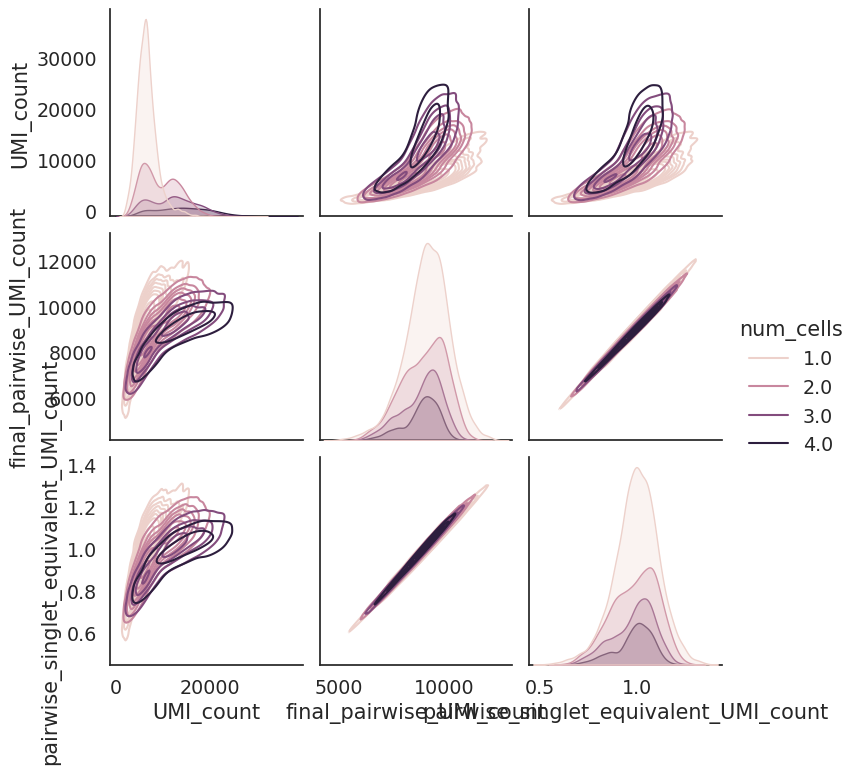

In [103]:
sns.pairplot(full_pop.cells.query('gem_group==1').dropna(subset='pairwise_singlet_equivalent_UMI_count')[['UMI_count', 'final_pairwise_UMI_count', 'pairwise_singlet_equivalent_UMI_count', 'num_cells']],
            hue='num_cells', kind='kde')

In [113]:
adata = sc.AnnData(X=csr_matrix(full_pop.matrix),
                   obs=full_pop.cells,
                   var=full_pop.genes)

In [114]:
adata.write('/data/norman/southark/tfs_standardized/240308_fibroblast_CRISPRa_final_pop.h5ad')